# Example - Harris / Lebofsky and Rieke - 433 Eros

In this notebook we show that our thermal model implementations are consistent to those published
in the literature. We take the data from Lebofsky and Rieke 1979 for asteroid Eros, and we grab the best-fit parameters published by Harris in 1998 that model these data. Using the published best-fit parameters, and the published data, we recreate Figure 1a in the Harris paper. 

This recreated figure serves as Figure 5 in the ATM paper.

See these papers for more details:  
http://adsabs.harvard.edu/abs/1979Icar...40..297L  
http://adsabs.harvard.edu/abs/1998Icar..131..291H  

In [1]:
import os 
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")

import atm

%matplotlib inline

In [2]:
DPI = 600
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = True

## Data Injest

In [3]:
from atm import Constants as c

m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

# Table 1 from Lebofsky paper (taking only data above 4 microns)
flux_nu_min = np.array([2.16, 11.8, 97, 103, 128, 141, 154, 168, 164])
flux_nu_max = np.array([7.13, 40, 289, 317, 388, 424, 457, 489, 480])
flux_nu_mean = (flux_nu_max + flux_nu_min) / 2
lambdas_microns = np.array([3.6, 4.9, 8.45, 8.76, 10.4, 11.6, 12.6, 19.0, 22.0])
num_obs = len(lambdas_microns)

# Convert to sensible units
flux_lambda_mean = flux_nu_mean / (lambdas_microns**2 * 1 / (c.LIGHTSPEED / 10**8) * 10**12)
flux_lambda_min = flux_nu_min / (lambdas_microns**2 * 1 / (c.LIGHTSPEED / 10**8) * 10**12)
flux_lambda_max = flux_nu_max / (lambdas_microns**2 * 1 / (c.LIGHTSPEED / 10**8) * 10**12)
flux_lambda_err = flux_lambda_max * np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.05, 0.05])

lambd = np.linspace(1e-6, 30e-6, 300)
num_sim = len(lambd)

# Observing geometry from Harris paper
r = np.ones(num_sim) * 1.134 
delta = np.ones(num_sim) * 0.153 
alpha = np.ones(num_sim) * np.radians(9.9)
eps = np.ones(num_sim) * 0.9 # unsure what values they assumed in Harris paper so we take a typical value
G = np.ones(num_sim) * 0.15 # unsure what values they assumed in Harris paper so we take a typical value

# Best fit values from Harris paper
FRM_eta = np.ones(num_sim) * np.pi # by definition
FRM_pv = np.ones(num_sim) * 0.09
FRM_D = np.ones(num_sim) * 36.2 * km_to_m

STM_eta = np.ones(num_sim) * 0.756 
STM_pv = np.ones(num_sim) * 0.27
STM_D = np.ones(num_sim) * 20.5 * km_to_m

NEATM_eta = np.ones(num_sim) * 1.05 
NEATM_pv = np.ones(num_sim) * 0.20
NEATM_D = np.ones(num_sim) * 23.6 * km_to_m

## Plot Data

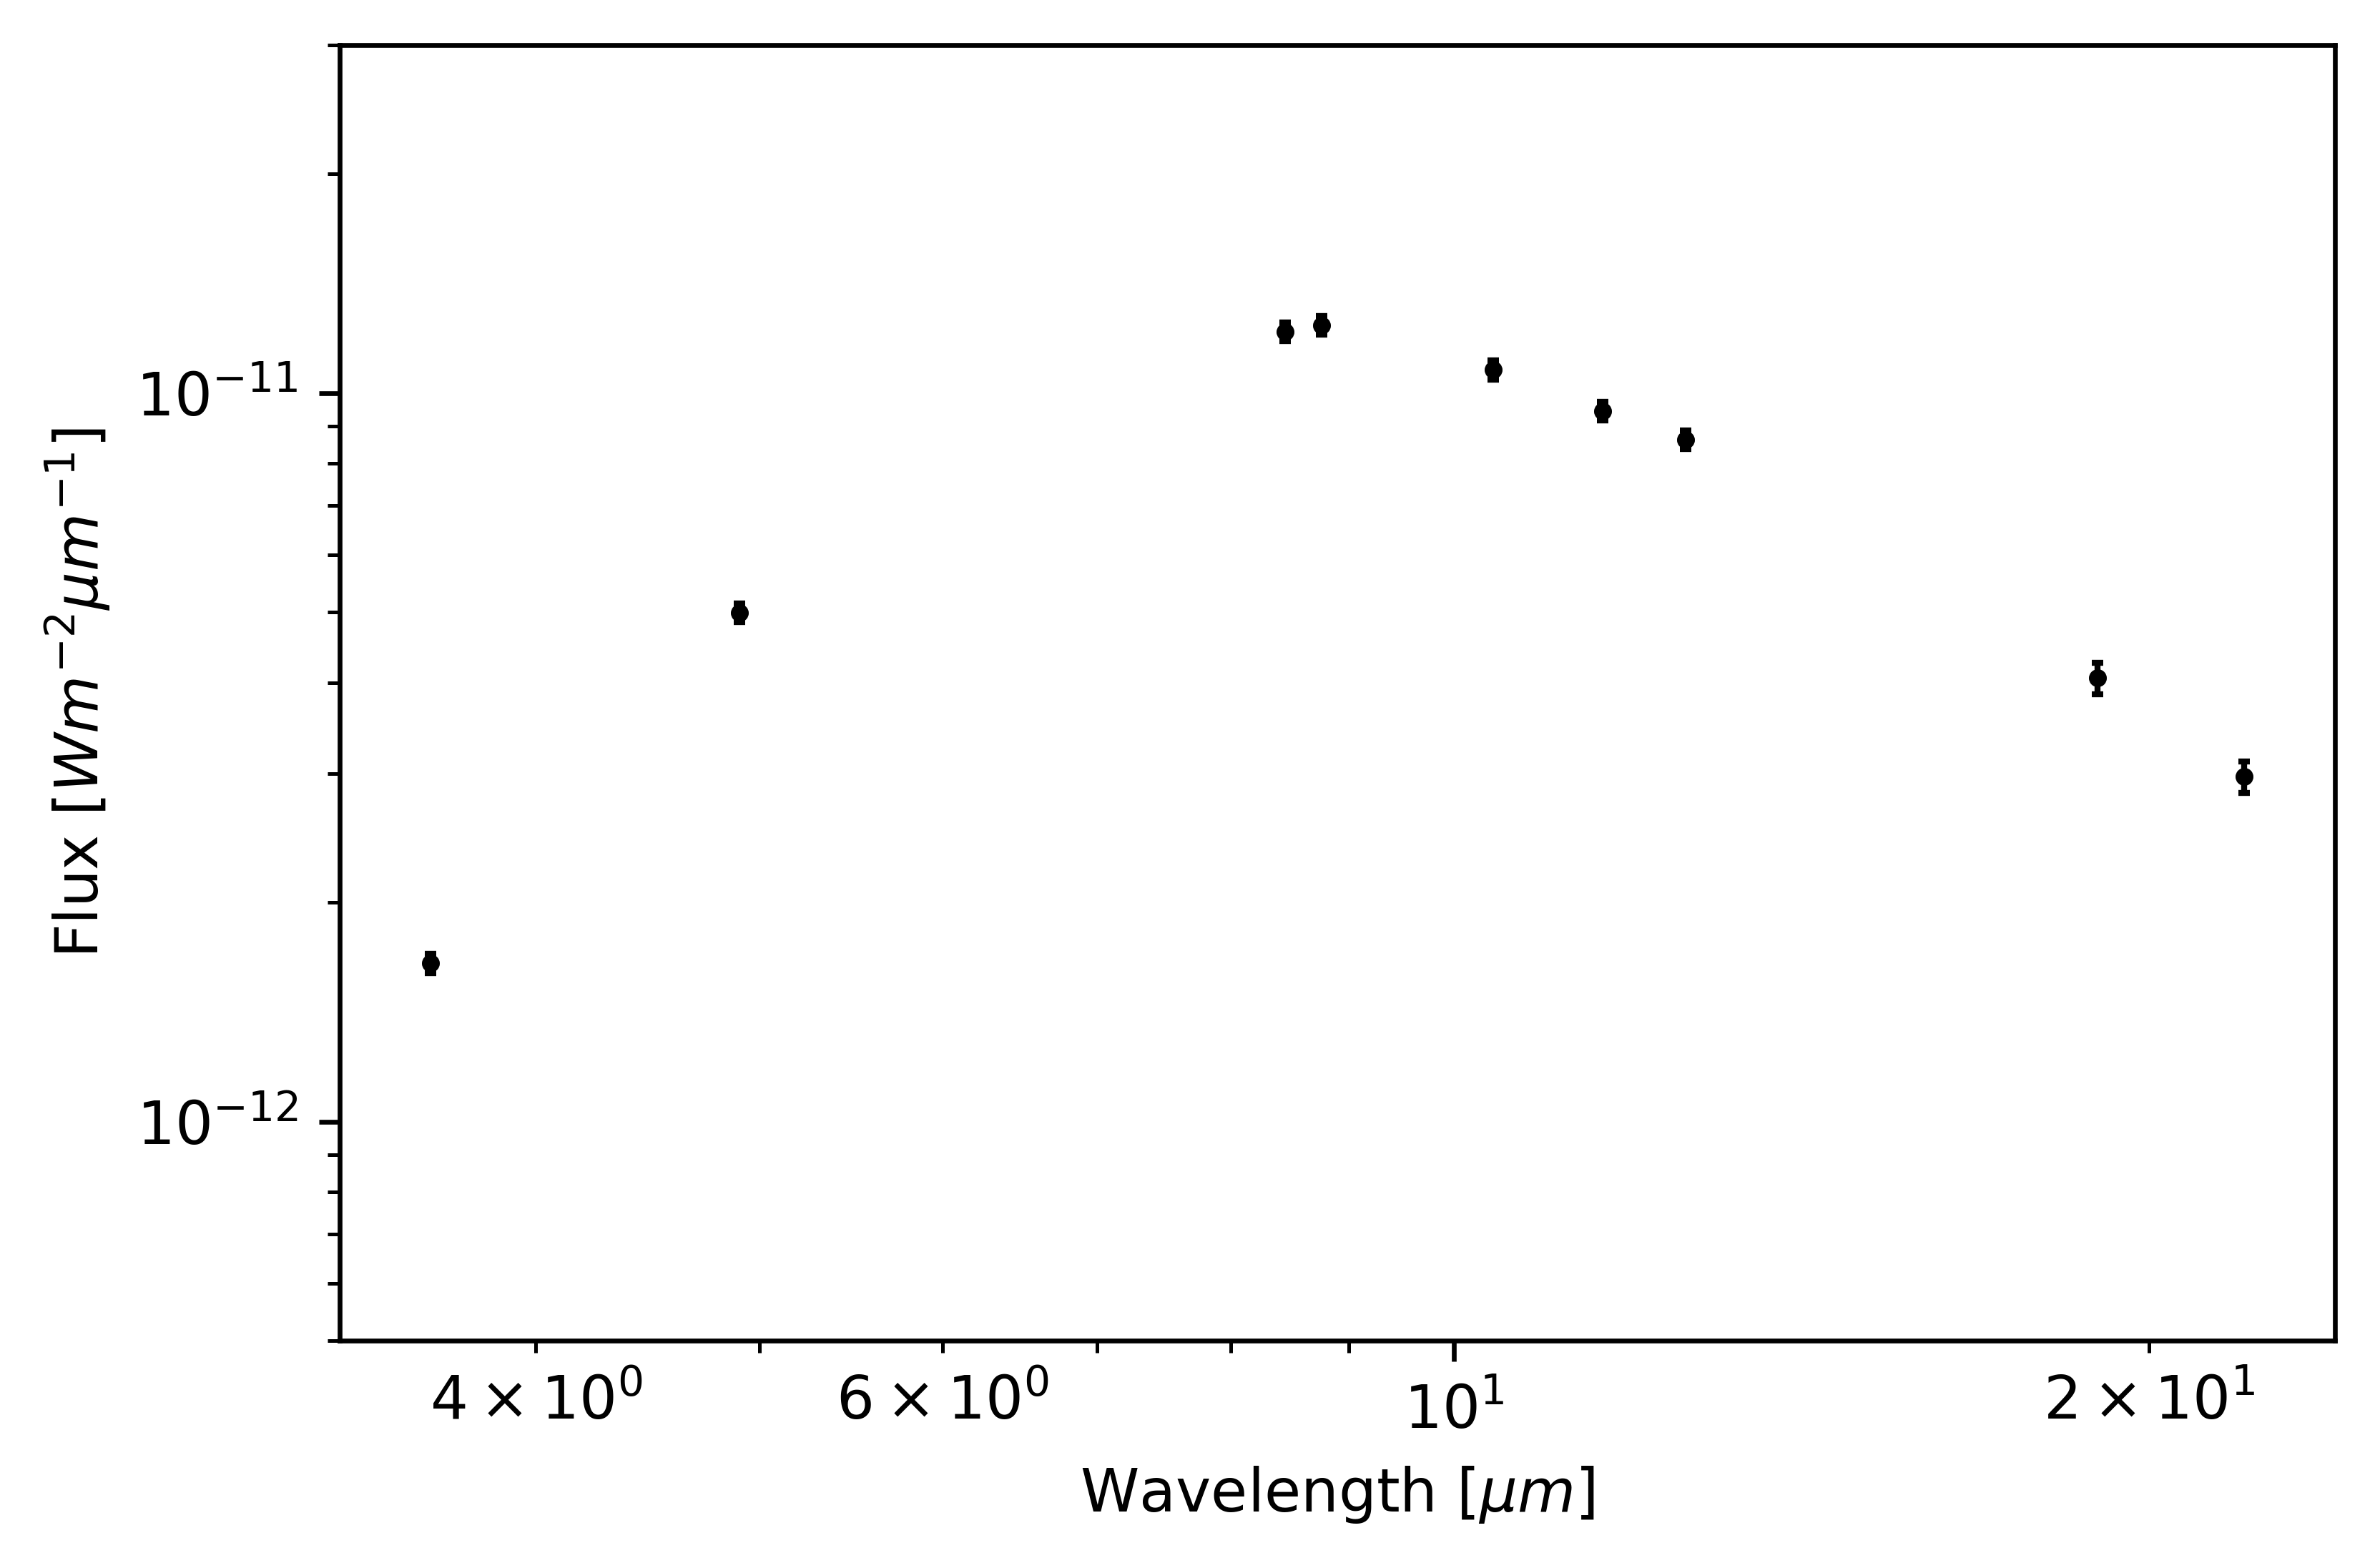

In [4]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.errorbar(lambdas_microns,
            flux_lambda_max, 
            yerr=flux_lambda_err,
            fmt='o',
            c="k",
            ms=2,
            capsize=1,
            elinewidth=1,
            label="Eros 433 - Harris / Lebofsky and Rieke")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Flux [$W m^{-2} \mu m^{-1}$]")
ax.set_xlabel(r"Wavelength [$\mu m$]")
ax.set_ylim(5e-13, 3e-11);

## Model Fluxes

In [5]:
from atm.models import STM, FRM, NEATM
from atm.functions import calcFluxLambdaAtObs, calcFluxLambdaAtObsWithSunlight
from atm.functions import calcTss
from atm.functions import calcQ

#### Standard Thermal Model (STM)

In [6]:
model = STM(verbose=False)

stm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, STM_pv, eps, G, STM_eta), STM_D, alpha, eps, STM_pv, G)

#### Fast-Rotating Model (FRM)

In [7]:
model = FRM(verbose=False)

frm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, FRM_pv, eps, G, FRM_eta), FRM_D, alpha, eps, FRM_pv,  G)

#### Near-Earth Asteroid Thermal Model (NEATM)

In [8]:
model = NEATM(verbose=False)

neatm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, NEATM_pv, eps, G, NEATM_eta), NEATM_D, alpha, eps, NEATM_pv, G)

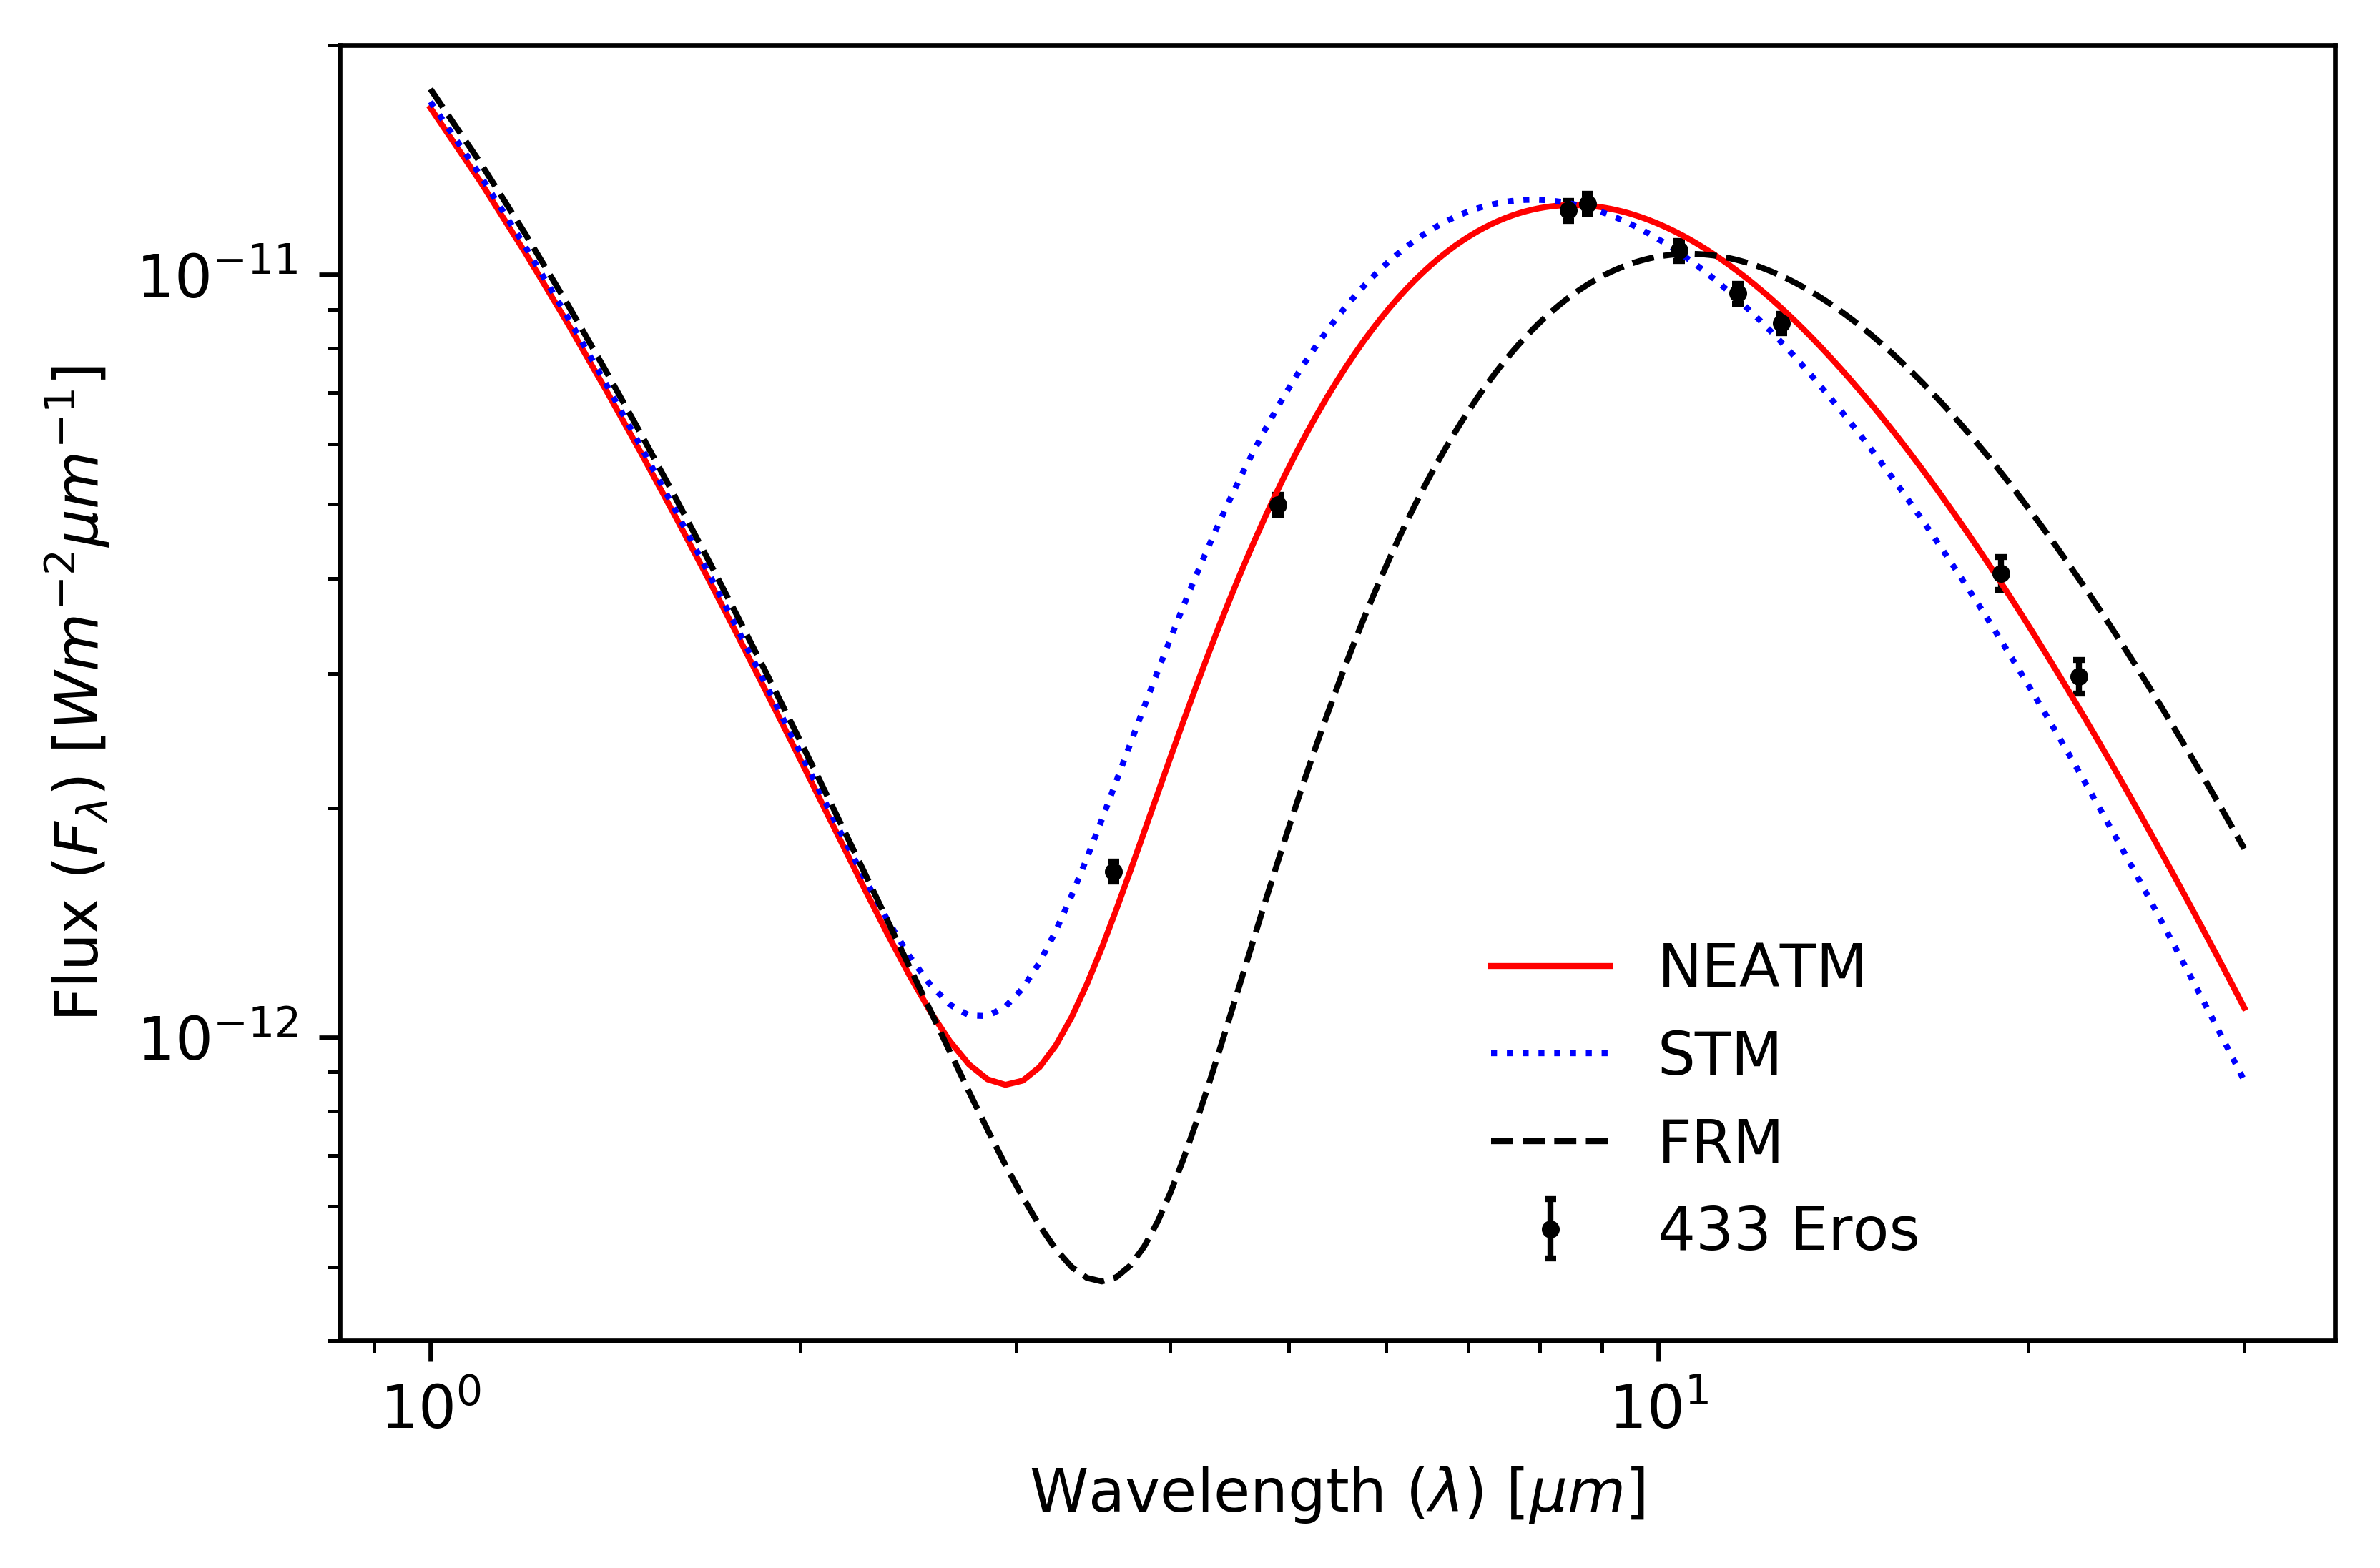

In [9]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.errorbar(lambdas_microns,
            flux_lambda_max, 
            yerr=flux_lambda_err,
            fmt='o',
            c="k",
            ms=2,
            capsize=1,
            elinewidth=1,
            label="433 Eros")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Flux ($F_\lambda$) [$W m^{-2} \mu m^{-1}$]")
ax.set_xlabel(r"Wavelength ($\lambda$) [$\mu m$]")

ax.plot(m_to_mum * lambd, 1/m_to_mum * neatm_flux_ws, lw=1, label="NEATM", c="r")
ax.plot(m_to_mum * lambd, 1/m_to_mum * stm_flux_ws, lw=1, label="STM", ls=":", c="b")
ax.plot(m_to_mum * lambd, 1/m_to_mum * frm_flux_ws, lw=1, label="FRM", ls="--", c="k")

ax.legend(bbox_to_anchor=(0.55,0.35), frameon=False)
ax.set_ylim(4e-13, 2e-11);
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "validation_Eros".format(FORMAT)), bbox_inches='tight')